In [61]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pandas as pd
import pathlib

In [62]:
data_dir = pathlib.Path('data/train/').with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

28709


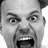

In [63]:
angry = list(data_dir.glob('angry/*'))
disgust = list(data_dir.glob('disgust/*'))
fear = list(data_dir.glob('fear/*'))
happy = list(data_dir.glob('happy/*'))
neutral = list(data_dir.glob('neutral/*'))
sad = list(data_dir.glob('sad/*'))
surprise = list(data_dir.glob('surprise/*'))

PIL.Image.open(str(angry[0]))
# PIL.Image.open(str(fear[0]))

In [64]:
batch_size = 32
img_height = 48
img_width = 48

In [65]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=None,
  color_mode='grayscale')

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=None,
  color_mode='grayscale')


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [66]:
# Save class names for later use
import json

class_names = raw_train_ds.class_names
print(class_names)

with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

# To load files
def load_class_names():
    with open('class_names.json', 'r') as f:
        return json.load(f)
    
num_classes = len(class_names)
    
# Example usage : predictd_class_name = class_names[predicted_index]

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [67]:
# Optimization and preprocessing

# Optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds
train_ds = train_ds.shuffle(buffer_size=1000)

# Cache & Batch & Prefetch
tarin_ds = train_ds.cache(filename='my_training_cache')
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = raw_val_ds
val_ds = val_ds.cache()
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [68]:
import numpy as np

# 3. Create a dictionary to map class names to their integer index
class_indices = {name: i for i, name in enumerate(class_names)}

# 4. Count the number of images in each class directory
class_counts = {name: len(list(data_dir.joinpath(name).glob('*.jpg'))) for name in class_names}
total_samples = sum(class_counts.values())
print(f"Class counts: {class_counts}")

# 5. Calculate the class weights manually
class_weight_dict = {}
for name, count in class_counts.items():
    weight = total_samples / (num_classes * count)
    class_index = class_indices[name]
    class_weight_dict[class_index] = weight

print("Calculated Class Weight Dictionary:", class_weight_dict)

Class counts: {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
Calculated Class Weight Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [69]:
num_classes = len(class_names)

# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")

In [70]:
# Ancient code for training from scratch - complete sequential without any transfer learning
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Model training
model_path = 'best_CNN_model.keras'
# Implement early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Save model periodically
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

# Training
print("No model weights found at", model_path)
print("Starting training from scratch.")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50,
  class_weight=class_weight_dict,
  callbacks=[early_stopping_callback, model_checkpoint_callback]
)

No model weights found at best_CNN_model.keras
Starting training from scratch.
Epoch 1/50


718/718 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.1997 - loss: 1.8808 - val_accuracy: 0.2912 - val_loss: 1.7867
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3139 - loss: 1.7552 - val_accuracy: 0.3555 - val_loss: 1.7074
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3581 - loss: 1.6608 - val_accuracy: 0.4261 - val_loss: 1.5088
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3891 - loss: 1.5907 - val_accuracy: 0.4137 - val_loss: 1.5333
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4104 - loss: 1.5292 - val_accuracy: 0.4576 - val_loss: 1.4356
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4251 - loss: 1.4724 - val_accuracy: 0.4684 - val_loss: 1.4001
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4332 - loss: 1.4334 - val_accuracy: 0.4635 - val_loss: 1.4020
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4444 - loss: 1.4079 - val_accuracy: 0.4647 - va

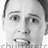

In [72]:
sample_img_path = fear[20]
PIL.Image.open(str(sample_img_path))

In [73]:

img = tf.keras.utils.load_img(
    str(sample_img_path),
    target_size=(img_width, img_height),
    color_mode="grayscale"
)

# img_array = np.array(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, 0)  # add batch dimension

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

predicted_index = np.argmax(score)
predicted_class_name = train_ds.class_names[predicted_index]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(predicted_class_name, 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'